In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from gmodel import grid

In [3]:
from respy import Fluid, RRock

In [4]:
from respy import rperm

#### Example 9.2. IMPES solution to two-phase flow in 1D with negligible capillary pressure and gravity.

Recall the 1D reservoir introduced in Example 3.4 which has reservoir length, $L$=4000 ft, width, $w$=1000 ft, and thickness $h$=20 ft.

The reservoir has an initial pressure of 3000 psia and the following homogenous reservoir properties: $\phi$ = 0.2, $k$ = 100 mD, $c_\text{f}$ 10e-6 1/psi.\
The fluid properties are $\mu_\text{o}$ = 5 cp, $c_\text{o}$ = 1e-5 1/psi, $B_\text{o}$ = 1 RB/STB and $\mu_\text{w}$ = 0.5 cp, $c_\text{w}$ = 1e-6 1/psi, $B_\text{w}$ = 1 RB/STB.

The initial water saturation ($S_\text{wi}$ = 0.20) is larger than the residual water saturation ($S_\text{wr}$ = 0.10).

Capillary pressure and gravity are negligible and relative permeability can be described by a BrookseCorey type relationship (Chapter 1) with $n_\text{o}$=$n_\text{w}$=2, $k_\text{ro}^0$ = 1.0, and $k_\text{rw}^0$ = 0.2, and $S_\text{or}$ = 0.2.

The boundary conditions are no flow at both ends. There is a water injector well at $x$ = 0 of 2000 scf/day and producer well of 2000 scf/day at $x$ = L.

Solve for the pressure and water saturation field after one timestep, $\Delta t$ = 1 day, using 4 uniform grids and the IMPES method.

## Input Data

In [5]:
grid = grid.GridDelta((1000,)*4,1000,20).grids

In [6]:
rock = RRock((100,)*4,poro=(0.2,)*4,comp=(1e-6,)*4)

In [7]:
oil = Fluid(5,comp=1e-5,fvf=1.)

In [8]:
water = Fluid(0.5,comp=1e-6,fvf=1.)

In [9]:
P0 = np.array((3000,)*4)
Sw0 = np.array((0.2,)*4)

## Relative Permeability Plotting

In [10]:
rp = rperm.BrooksCorey(swr=0.1, sor=0.2, k0rw=0.2, k0ro=1.0, nw=2, no=2)

In [11]:
rp.get(0.2)

(array([0.00408163]), array([0.73469388]))

In [12]:
Sw = np.linspace(0,1,1000)
krw,kro = rp.get(Sw)

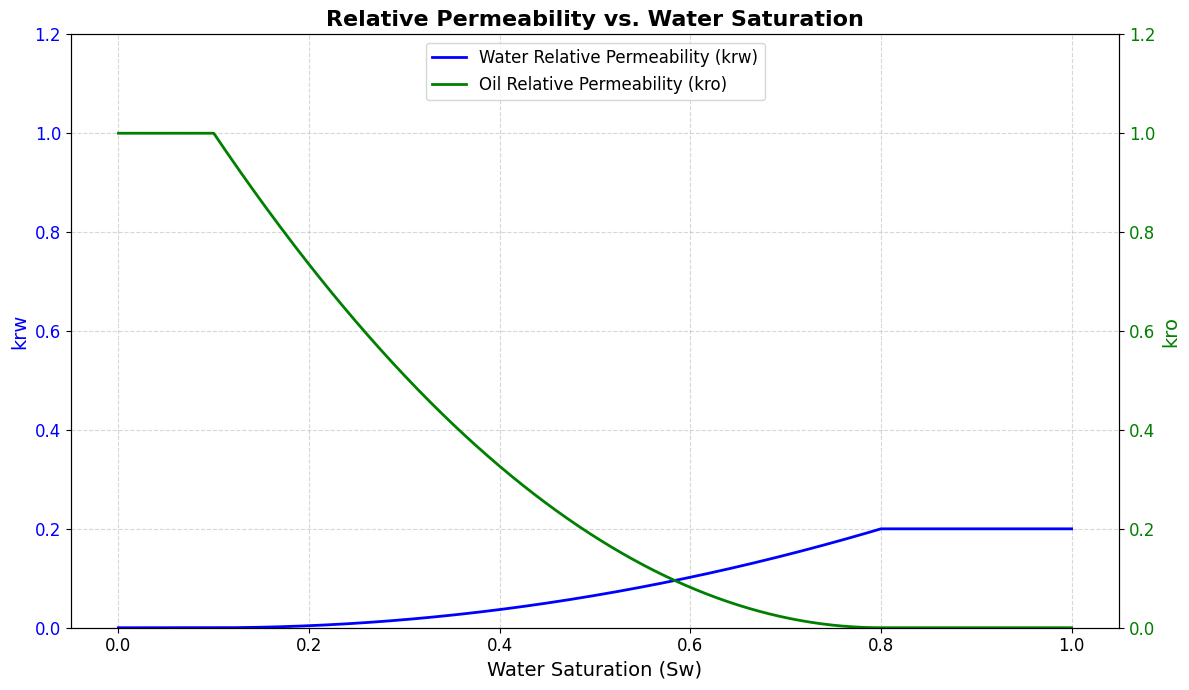

In [14]:
fig, ax1 = plt.subplots(figsize=(12, 7))
ax2 = ax1.twinx()

# Plot water relative permeability
line1, = ax1.plot(Sw, krw, 'b-', label='Water Relative Permeability (krw)', linewidth=2, markersize=6)

# Plot oil relative permeability
line2, = ax2.plot(Sw, kro, 'g-', label='Oil Relative Permeability (kro)', linewidth=2, markersize=6)

# Titles and labels
ax1.set_title('Relative Permeability vs. Water Saturation', fontsize=16, fontweight='bold')
ax1.set_xlabel('Water Saturation (Sw)', fontsize=14)
ax1.set_ylabel('krw', color='b', fontsize=14)
ax2.set_ylabel('kro', color='g', fontsize=14)

# Y-axis limits
ax1.set_ylim(0, 1.2)
ax2.set_ylim(0, 1.2)

# Grid for readability
ax1.grid(True, linestyle='--', alpha=0.5)

# Combine legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper center', fontsize=12)

# Ticks customization
ax1.tick_params(axis='y', labelcolor='b')
ax2.tick_params(axis='y', labelcolor='g')
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

# IMPES

In [9]:
tdelta = 1.0

In [10]:
Rock = (rock_perm*area)/edge*1.06235016e-14

In [11]:
Rock

2.12470032e-11

In [12]:
Mw = krw(init_swater)/(wat_mu*wat_fvf)*(24*60*60)/1.4503774389728e-7
Tw = Rock*Mw

In [13]:
Tw

0.10332235622243502

In [14]:
Mo = kro(init_swater)/(oil_mu*oil_fvf)*(24*60*60)/1.4503774389728e-7
To = Rock*Mo

In [15]:
T = Tw+To

In [16]:
T

1.9631247682262647

In [17]:
def ct(cr,co,cw,Sw):
  return cr+Sw*cw+(1-Sw)*co

In [18]:
tcomp = ct(rock_comp,oil_comp,wat_comp,init_swater)

In [19]:
A = area*edge*rock_poro/tdelta

In [20]:
Act = A*tcomp

In [21]:
Act

36.800000000000004

In [22]:
Q = np.zeros((4,1))

In [23]:
Qw1 = 2000
Qo1 = 0

In [24]:
Q[0,0] = Qw1+Qo1

In [25]:
Qw4 = Mw/(Mw+Mo)*(-2000)

In [26]:
Qo4 = -2000-Qw4

In [27]:
Q[3,0] = Qw4+Qo4

In [28]:
Qw4

-105.26315789473688

In [29]:
Qo4

-1894.7368421052631

In [30]:
Q

array([[ 2000.],
       [    0.],
       [    0.],
       [-2000.]])

In [31]:
trans = np.zeros((4,4))
diag = np.zeros((4,4))

In [32]:
for i in range(4):
  if i == 0:
    trans[i,i] = 1
    trans[i,i+1] = -1
  elif i == 3:
    trans[i,i] = 1
    trans[i,i-1] = -1
  else:
    trans[i,i] = 2
    trans[i,i+1] = -1
    trans[i,i-1] = -1
  diag[i,i] = 1

In [33]:
diag

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [34]:
P = np.array([3000,3000,3000,3000]).reshape((-1,1))

In [35]:
P

array([[3000],
       [3000],
       [3000],
       [3000]])

In [36]:
LHS = T*trans+Act*diag

In [37]:
LHS

array([[38.76312477, -1.96312477,  0.        ,  0.        ],
       [-1.96312477, 40.72624954, -1.96312477,  0.        ],
       [ 0.        , -1.96312477, 40.72624954, -1.96312477],
       [ 0.        ,  0.        , -1.96312477, 38.76312477]])

In [41]:
RHS = np.matmul(Act*diag,P)+Q

In [42]:
RHS

array([[112400.],
       [110400.],
       [110400.],
       [108400.]])

In [43]:
np.linalg.solve(LHS,RHS)

array([[3051.71587053],
       [3002.37821959],
       [2997.62178041],
       [2948.28412947]])